In [37]:
import numpy as np
from numpy.random import rand

In [38]:
def spikes_poisson(taxa, N_exc, N_ini, peso_exc, peso_ini, dt):
    # Gera N_exc + N_ini entradas Poisson, dados os pesos e a taxa
    
    spikes = rand(N_exc + N_ini) < taxa * dt
    return spikes * np.r_[peso_exc*np.ones(N_exc), peso_ini*np.ones(N_ini)]
    

In [39]:
def espectro(serie, dt):
    # Calcula a densidade espectral de potência pelo método de Welch
    from scipy.signal import welch
    
    return welch(serie, 1/dt) 

In [40]:
def local_field_potential(I_exc, I_ini, N_exc):
    # calcula sinal de LFP dadas correntes excitatória e inibitória
    R = 1  # Resistência do eletrodo (Mohm)
    return(R/N_exc) * (np.sum(I_exc[:N_exc,:],0)+np.sum(abs(I_ini[:N_exc,:]),0))


In [41]:
def izhikevich(passos, dt, tx_poisson, peso_E, peso_I):
    '''
        Simulação da rede de neurônios descrita em
            Eugene M. Izhikevich. Simple model of spiking neurons.
            IEEE Transactions on neural networks. 14, 6 (2003).
    '''
        
    Ne = 800   # Número de neurônios excitatórios
    Ni = 200   # Número de neurônios inibitórios
    re = rand(Ne) # Ne valores aleatórios entre 0 e 1
    ri = rand(Ni) # Ni valores aleatórios entre 0 e 1
    
    # Parâmetros da simulação
    transiente = passos # no. de pontos a jogar fora (transiente)
    
    # Parâmetros do modelo
    a = np.r_[0.02*np.ones(Ne),  0.02 + 0.08 * ri]
    b = np.r_[0.2*np.ones(Ne),   0.25 - 0.05 * ri]
    c = np.r_[-65+15*re**2,      -65 * np.ones(Ni)]
    d = np.r_[8-6*re**2,         2 * np.ones(Ni)]

    # Pesos Sinápticos
    S = np.c_[0.5*rand(Ne+Ni,Ne), -rand(Ne+Ni,Ni)]

    # Condições iniciais
    v = -65*np.ones(Ne+Ni)    
    u = b * v      
    
    # Matrizes para Correntes
    Ie = np.zeros((Ne+Ni,passos))
    Ii = np.zeros((Ne+Ni,passos))
        
    dt2 = dt * 1000 / 2  # meio passo de integração, em ms
    disparos = []        # lista de spikes

    for _ in range(transiente):  # simular por `transiente` passos de tamanho`dt`
        
        # entrada talâmica
        Iext = spikes_poisson(tx_poisson, Ne, Ni, peso_E, peso_I, dt)

        fired = np.flatnonzero(v >= 30)  # índices das células que dispararam
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        I = Iext + np.sum(S[:,fired], 1)
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # usar dois passos de dt/2
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # na dinâmica de v, para
        u = u + 2 * dt2 * (a * (b * v - u))           # maior estabilidade numérica

    for t in range(passos):
        fired = np.flatnonzero(v >= 30)  # índices das células que dispararam
        for nrn in fired:
            disparos.append((nrn, t))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]

        Ie[:,t] = np.sum(S[:,fired[fired<Ne]],1)  # Corrente excitatória
        Ii[:,t] = np.sum(S[:,fired[fired>=Ne]],1) # Corrente inibitória
        
        # entrada talâmica
        Iext = spikes_poisson(tx_poisson, Ne, Ni, peso_E, peso_I, dt)  

        I = Iext + Ie[:,t] + Ii[:,t]

        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # usar dois passos de dt/2 
        v = v + dt2 * (0.04*v**2 + 5*v + 140 - u + I) # na dinâmica de v, para
        u = u + 2*dt2 * (a * (b * v - u))             # maior estabilidade numérica
    
    
    return disparos, local_field_potential(Ie, Ii, Ne)

In [42]:
# Exemplo de simulação da rede 
passos = 2000 # no. de passos na simulação
dt = 0.001 # passo de integração em s
tx_poisson = 100 # taxa em Hz
disparos, LFP = izhikevich(passos, dt, tx_poisson, 15, 6)

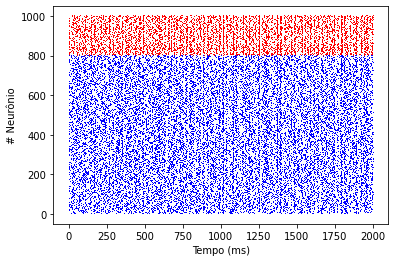

In [43]:
import matplotlib.pylab as plt

# Exemplo de raster plot
plt.figure(1)
disparos = np.array(disparos) 
plt.xlabel('Tempo (ms)')
plt.ylabel('# Neurônio')
plt.plot(disparos[disparos[:,0]<800,1], disparos[disparos[:,0]<800,0],',b')
plt.plot(disparos[disparos[:,0]>=800,1], disparos[disparos[:,0]>=800,0],',r')

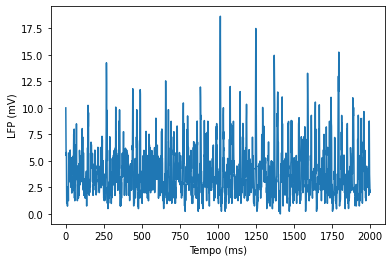

In [44]:
# Exemplo de sinal de LFP
plt.figure(2)
plt.xlabel('Tempo (ms)')
plt.ylabel('LFP (mV)')
plt.plot(LFP)

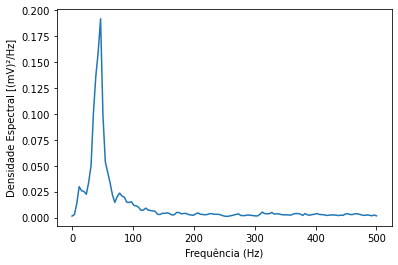

In [45]:
# Exemplo de espectro
freq, S = espectro(LFP, dt)
plt.figure(3)
plt.xlabel('Frequência (Hz)')
plt.ylabel(r'Densidade Espectral [(mV)²/Hz]')
plt.plot(freq, S)

Text(0, 0.5, 'Contagem')

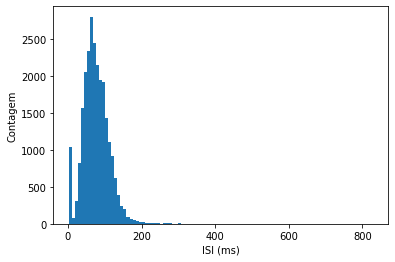

In [46]:
# Histograma dos ISI

# Dicionário com disparos para cada neurônio
nrn_spikes = {i: [] for i in range(1000)}
for nrn, tspk in disparos:
    nrn_spikes[nrn].append(tspk)

# Lista com todos os ISI
isis = []
for n in nrn_spikes:  # calculamos os ISI para cada um dos neurônios
    tspks = nrn_spikes[n]
    isi = np.diff(tspks)
    isis.extend(isi)  # listona com todos os ISI da rede

plt.figure(4)
plt.hist(isis, bins=100)
plt.xlabel('ISI (ms)')
plt.ylabel('Contagem')

(array([32., 20., 16., ...,  8.,  7.,  7.]),
 array([0.0000000e+00, 9.9950000e-01, 1.9990000e+00, ..., 1.9970010e+03,
        1.9980005e+03, 1.9990000e+03]),
 <BarContainer object of 2000 artists>)

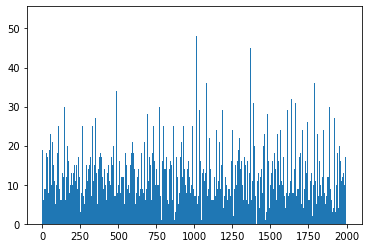

In [47]:
# Taxa de disparos da rede
plt.figure(5)
plt.hist(disparos[:,1], 2000) # histograma com 2000 canaletas